In [ ]:
import csv
import json
import sys
import umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from pathlib import Path
from typing import List, Dict, Set
import torch
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
print(torch.cuda.is_available())


/home/marcelo-julian-baez-ferreira/phd/visualization/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


### Utils

In [107]:
def load_json(file_path):
    """
    Load a JSON file and return its content as a Python dictionary.

    :param file_path: Path to the JSON file.
    :return: Dictionary containing the JSON data.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

def get_participants_communications(event_id: str, nodes, edges):
    sent_edge = next((e for e in edges if e.get('type') == 'sent' and e.get('target') == event_id), None)
    # Find the 'received' edge where source is the event
    received_edge = next((e for e in edges if e.get('type') == 'received' and e.get('source') == event_id), None)

    if not sent_edge or not received_edge:
        return None, None

    source_entity_id = sent_edge['source']
    target_entity_id = received_edge['target']

    source_node = next((n for n in nodes if n.get('id') == source_entity_id), None)
    target_node = next((n for n in nodes if n.get('id') == target_entity_id), None)

    return source_node, target_node

def get_participants_and_evidence_relationships(event_id: str, nodes, edges):
    """
    This function give us the participant of between two entities in a relationship. Excluding the evidence
    """
    _edges = []
    for edge in edges:
        if edge.get('target') == event_id:
            _edges.append(edge)

    if len(_edges) < 2:
        return None, None
    _participant1 = _edges[0]
    _participant2 = _edges[1]
    _evidence = _edges[2] if len(_edges) > 2 else None
    source_entity_id = _participant1['source']
    target_entity_id = _participant2['source']
    _evidence = _evidence['source'] if _evidence else None

    source_node = next((n for n in nodes if n.get('id') == source_entity_id), None)
    target_node = next((n for n in nodes if n.get('id') == target_entity_id), None)

    return source_node, target_node, _evidence


def create_csv(file_path: str, data: list, headers: List[str] = None):
    """
    Create a CSV file from a list of tuples.
    :param file_path: Path to the output CSV file.
    :param data: List of tuples containing the data to write to the CSV file.
    """
    with open(file_path, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        if headers:
            writer.writerow(headers)
        for row in data:
            writer.writerow(row)

def plot_heat_map(matrix, title="Heatmap", cmap='viridis', annotate=False):
    """
    Plot a heatmap of the given matrix.
    
    :param matrix: DataFrame or 2D array-like object to visualize.
    :param title: Title of the heatmap.
    :param cmap: Colormap to use for the heatmap.
    :param annotate: If True, display the numeric value on each square.
    """
    plt.figure(figsize=(10, 8))
    img = plt.imshow(matrix, aspect='auto', cmap=cmap)
    plt.colorbar(img)
    plt.title(title)
    
    # Set ticks if matrix is a DataFrame
    if hasattr(matrix, 'columns') and hasattr(matrix, 'index'):
        plt.xticks(ticks=np.arange(len(matrix.columns)), labels=matrix.columns, rotation=90)
        plt.yticks(ticks=np.arange(len(matrix.index)), labels=matrix.index)
    else:
        plt.xticks(ticks=np.arange(np.shape(matrix)[1]))
        plt.yticks(ticks=np.arange(np.shape(matrix)[0]))
    
    # Annotate each cell with its numeric value if required.
    if annotate:
        # Obtain the data as a numpy array.
        data = matrix.values if hasattr(matrix, 'values') else np.array(matrix)
        rows, cols = data.shape
        for i in range(rows):
            for j in range(cols):
                plt.text(j, i, f'{data[i, j]:.2f}', ha='center', va='center', color='white', fontsize=8)
    
    plt.tight_layout()
    plt.show()

def reduce_dimensions(embeddings: np.ndarray, n_components: int = 3) -> np.ndarray:
    """
    Reduce the dimensionality of embeddings using UMAP.
    """
    reducer = umap.UMAP(n_components=n_components, random_state=42)
    return reducer.fit_transform(embeddings)

def plot_3d_embeddings(embeddings: np.ndarray, labels: List[str] = None):
    """
    Plot 3D embeddings using matplotlib without labels.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c='b', marker='o')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.show()

def plot_clusters(embeddings: np.ndarray, clusters: np.ndarray):
    """
    Plot the clustered embeddings in 3D space.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    unique_clusters = np.unique(clusters)
    for cluster in unique_clusters:
        cluster_points = embeddings[clusters == cluster]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {cluster}')
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.legend()
    plt.show()

    


## Parsing data for PAOHVIS

In [7]:
def collect_entity_names(nodes: List[Dict]) -> Set[str]:
    """Return a set with the *unique* names of all entities."""
    return {n["name"] for n in nodes if n.get("type") == "Entity"}

def extract_time_slot(raw_ts: str) -> str:
    """Convert full timestamp to a coarse *time‑slot* accepted by PAOHVis.

    Currently we keep the **date** part (`YYYY‑MM‑DD`). If `raw_ts` is null or
    malformed, we return "unknown" so the record still loads.
    """
    if not raw_ts:
        return "unknown"
    try:
        return datetime.fromisoformat(raw_ts).date().isoformat()
    except ValueError:
        return raw_ts
    
def detect_participants(content: str, entity_names: Set[str]) -> Set[str]:
    """Return the subset of `entity_names` that occur inside `content`."""
    participants = {name for name in entity_names if name in content}
    return participants

In [8]:
nodes = data.get("nodes", [])
edges = data.get("edges", [])
entity_names = collect_entity_names(nodes)

In [9]:
len(entity_names)

72

In [147]:
messages_df.shape

(584, 7)

In [153]:
messages_df

,event_id,datetime,content,source,target,embedding,fcluster
0,1,2040-10-01 08:09:00,"Hey The Intern, it's The Lookout! Just spotted...",The Lookout,The Intern,"[0.02924199216067791, -0.04186283424496651, 0....",4
1,2,2040-10-01 08:10:00,"Hey The Lookout, The Intern here! I'd absolute...",The Intern,The Lookout,"[0.03175387531518936, -0.05981292948126793, 0....",4
2,3,2040-10-01 08:13:00,"Sam, it's Kelly! Let's meet at Sunrise Point a...",Kelly,Sam,"[0.017817039042711258, -0.049655403941869736, ...",4
3,5,2040-10-01 08:16:00,"Mrs. Money, it's The Intern. Just checking in ...",The Intern,Mrs. Money,"[0.02555181086063385, -0.03967339172959328, -0...",1
4,6,2040-10-01 08:19:00,"Boss, it's Mrs. Money. I've reviewed our opera...",Mrs. Money,Boss,"[0.03286126255989075, -0.03731901943683624, -0...",4
...,...,...,...,...,...,...,...
579,994,2040-10-14 12:50:00,"Green Guardians, Oceanus City Council here. Yo...",Oceanus City Council,Green Guardians,"[0.003793498734012246, -0.02744883857667446, 0...",4
580,997,2040-10-14 12:51:00,"EcoVigil, Green Guardians HQ here. Your video ...",Green Guardians,EcoVigil,"[0.017483510076999664, -0.03820016235113144, 0...",4
581,999,2040-10-14 13:31:00,Defender to Mako. Be advised that conservation...,Defender,Mako,"[0.020824257284402847, -0.013889516703784466, ...",4
582,1001,2040-10-14 13:34:00,"Knowles, Mako here. Proceed to southern dock a...",Knowles,Davis,"[0.03646671399474144, -0.04940148442983627, 0....",4


In [162]:
persons[persons['id'] == 'Sam'].is_pseudonym.values[0] == False

np.True_

In [167]:
fieldnames = ['edge_id', 'node_name', 'time_slot', 'edge_name_description', 'group_name', 'role']
messages_paohvis = []
for i in range(messages_df.shape[0]):
    row = messages_df.iloc[i]
    edge_id = row['event_id']
    source_node_name = row['source']
    target_node_name = row['target']
    time_slot = row['datetime']
    edge_name_description = row['content']
    group_name = row['fcluster']
    person_data_1 = persons[persons['id'] == row['source']]
    person_data_2 = persons[persons['id'] == row['target']]

    if person_data_1.empty:
        print(f"Warning: No person found for source {row['source']}")
        role = 'vessel'
    elif person_data_1.is_pseudonym.values[0]:
        role = 'pseudonym'
    else:
        role = 'person'
    messages_paohvis.append([edge_id, source_node_name, time_slot, edge_name_description, group_name, role])
    if person_data_2.empty:
        print(f"Warning: No person found for target {row['target']}")
        role = 'vessel'
    elif person_data_2.is_pseudonym.values[0]:
        role = 'pseudonym'
    else:
        role = 'person'
    messages_paohvis.append([edge_id, target_node_name, time_slot, edge_name_description, group_name, role])

create_csv('../data/MC3_messages.csv', messages_paohvis, fieldnames)


In [ ]:
# Create a CSV file with the required columns
output_file = '../data/MC3_data_parsed.csv'
with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['edge_id', 'node_name', 'time_slot', 'edge_name_description', 'group_name', 'role']
    writer = csv.writer(csvfile)
    writer.writerow(fieldnames)
    for event in nodes:
            if event.get("type") == "Event" and event.get("sub_type") == "Communication":
                edge_id = event.get("id")
                time_slot = extract_time_slot(event.get("timestamp"))
                content = event.get("content", "")
                # A short description—trim content to first 60 chars
                edge_desc = content[:60] + ("…" if len(content) > 60 else "")

                participants = detect_participants(content, entity_names)
                if not participants:
                    # Fallback: unknown sender/receiver – still output a single row
                    writer.writerow([edge_id, "_unknown_", time_slot, edge_desc, "", ""])
                else:
                    for name in participants:
                        writer.writerow([edge_id, name, time_slot, edge_desc, "", ""])
print(f"Data parsed and saved to {output_file}")

## Question 3

1. Expanding upon your prior visual analytics, determine who is using pseudonyms to communicate, and what these pseudonyms are.
2. Describe how your visualization makes it easier to identify common entities in the data.
3. How does your understanding of activities change given your understanding of pseudonyms

In [ ]:
data = load_json('../data/MC3_graph.json')
schema = load_json('../data/MC3_schema.json')
nodes_type = schema['schema']['nodes'].keys()
# Process the data to differentes kinds of events
nodes = data.get("nodes", [])get_participants_relationships
edges = data.get("edges", [])

### Data Preparation



I'm classifying the entities in the data as follows:
- **Pseudonyms**: These are names that users have chosen to represent themselves, which may not correspond to their real names.

In [7]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [6]:
entities = []
for entity in nodes:
    if entity.get("type") == "Entity":
        entities.append(entity)

entities_df = pd.DataFrame(entities).drop(columns=['type'])
entities_df

,label,name,sub_type,id
0,Sam,Sam,Person,Sam
1,Kelly,Kelly,Person,Kelly
2,Nadia Conti,Nadia Conti,Person,Nadia Conti
3,Elise,Elise,Person,Elise
4,Liam Thorne,Liam Thorne,Person,Liam Thorne
...,...,...,...,...
67,Route C,Route C,Location,Route C
68,South Dock,South Dock,Location,South Dock
69,Castaway Cove,Castaway Cove,Location,Castaway Cove
70,Berth 14,Berth 14,Location,Berth 14


In [8]:
entities_df['Spacy_type'] = entities_df['name'].apply(lambda x: nlp(x).ents[0].label_ if nlp(x).ents else 'N/A')
entities_df['Spacy_type'].value_counts()

Spacy_type
N/A         30
ORG         16
PERSON      14
NORP         4
GPE          3
LOC          2
PRODUCT      1
FAC          1
CARDINAL     1
Name: count, dtype: int64

In [9]:
entities_df

,label,name,sub_type,id,Spacy_type
0,Sam,Sam,Person,Sam,PERSON
1,Kelly,Kelly,Person,Kelly,N/A
2,Nadia Conti,Nadia Conti,Person,Nadia Conti,ORG
3,Elise,Elise,Person,Elise,N/A
4,Liam Thorne,Liam Thorne,Person,Liam Thorne,PERSON
...,...,...,...,...,...
67,Route C,Route C,Location,Route C,N/A
68,South Dock,South Dock,Location,South Dock,NORP
69,Castaway Cove,Castaway Cove,Location,Castaway Cove,N/A
70,Berth 14,Berth 14,Location,Berth 14,CARDINAL


Person entities are classified as pseudonyms if they are not recognized as real people by the Spacy model. This is done by checking if the entity label is 'PERSON' and if the entity text is not in the list of known real names.

In [10]:
persons = entities_df[entities_df['sub_type'] == 'Person']

In [124]:
persons['is_pseudonym'] = False

/tmp/ipykernel_731169/2040668371.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  persons['is_pseudonym'] = False


In [131]:
persons.to_csv('../data/MC3_persons.csv', index=False)

In [126]:
names = persons['name'].tolist()
for name in names:
    doc = nlp(name)
    if doc.ents:
        for ent in doc.ents:
            if ent.label_ == "PERSON":
                print(f"Found named entity: {ent.text} in name: {name}")
                persons.loc[persons['name'] == name, 'is_pseudonym'] = False
                break
            else:
                persons.loc[persons['name'] == name, 'is_pseudonym'] = True
    else:
        print(f"No named entity found in name: {name}")
        persons.loc[persons['name'] == name, 'is_pseudonym'] = True

Found named entity: Sam in name: Sam
No named entity found in name: Kelly
No named entity found in name: Elise
Found named entity: Liam Thorne in name: Liam Thorne
Found named entity: Samantha Blake in name: Samantha Blake
Found named entity: Davis in name: Davis
No named entity found in name: Rodriguez
No named entity found in name: Sailor Shift
Found named entity: Clepper Jensen in name: Clepper Jensen
Found named entity: Miranda Jordan in name: Miranda Jordan
No named entity found in name: The Intern
No named entity found in name: The Accountant
Found named entity: Money in name: Mrs. Money
No named entity found in name: The Middleman
No named entity found in name: Boss
No named entity found in name: Small Fry


In [11]:
persons

,label,name,sub_type,id,Spacy_type
0,Sam,Sam,Person,Sam,PERSON
1,Kelly,Kelly,Person,Kelly,N/A
2,Nadia Conti,Nadia Conti,Person,Nadia Conti,ORG
3,Elise,Elise,Person,Elise,N/A
4,Liam Thorne,Liam Thorne,Person,Liam Thorne,PERSON
5,Samantha Blake,Samantha Blake,Person,Samantha Blake,PERSON
6,Davis,Davis,Person,Davis,PERSON
7,Rodriguez,Rodriguez,Person,Rodriguez,N/A
8,Sailor Shift,Sailor Shift,Person,Sailor Shift,N/A
9,Clepper Jensen,Clepper Jensen,Person,Clepper Jensen,PERSON


Processing the events, for this case i want to aggregate the communications

In [159]:
messages = []
for event in nodes:
    if event.get("type") == "Event":
        if event.get("sub_type") == "Communication":
            event_id = event.get("id")
            time_slot = event.get("timestamp")
            content = event.get("content", "")
            participants = get_participants_communications(event_id, nodes, edges)
            messages.append(
                {
                    "event_id": event_id,
                    "datetime": time_slot,
                    "content": content,
                    "source": participants[0],
                    "target": participants[1] 
            }
        )
messages_df = pd.DataFrame(messages)

In [165]:
messages_df

,event_id,datetime,content,source,target,src_dict,tgt_dict,src_node,tgt_node
0,Event_Communication_1,2040-10-01 08:09:00,"Hey The Intern, it's The Lookout! Just spotted...","{'type': 'Entity', 'label': 'The Lookout', 'na...","{'type': 'Entity', 'label': 'The Intern', 'nam...","{'type': 'Entity', 'label': 'The Lookout', 'na...","{'type': 'Entity', 'label': 'The Intern', 'nam...",The Lookout,The Intern
1,Event_Communication_2,2040-10-01 08:10:00,"Hey The Lookout, The Intern here! I'd absolute...","{'type': 'Entity', 'label': 'The Intern', 'nam...","{'type': 'Entity', 'label': 'The Lookout', 'na...","{'type': 'Entity', 'label': 'The Intern', 'nam...","{'type': 'Entity', 'label': 'The Lookout', 'na...",The Intern,The Lookout
2,Event_Communication_3,2040-10-01 08:13:00,"Sam, it's Kelly! Let's meet at Sunrise Point a...","{'type': 'Entity', 'label': 'Kelly', 'name': '...","{'type': 'Entity', 'label': 'Sam', 'name': 'Sa...","{'type': 'Entity', 'label': 'Kelly', 'name': '...","{'type': 'Entity', 'label': 'Sam', 'name': 'Sa...",Kelly,Sam
3,Event_Communication_5,2040-10-01 08:16:00,"Mrs. Money, it's The Intern. Just checking in ...","{'type': 'Entity', 'label': 'The Intern', 'nam...","{'type': 'Entity', 'label': 'Mrs. Money', 'nam...","{'type': 'Entity', 'label': 'The Intern', 'nam...","{'type': 'Entity', 'label': 'Mrs. Money', 'nam...",The Intern,Mrs. Money
4,Event_Communication_6,2040-10-01 08:19:00,"Boss, it's Mrs. Money. I've reviewed our opera...","{'type': 'Entity', 'label': 'Mrs. Money', 'nam...","{'type': 'Entity', 'label': 'Boss', 'name': 'B...","{'type': 'Entity', 'label': 'Mrs. Money', 'nam...","{'type': 'Entity', 'label': 'Boss', 'name': 'B...",Mrs. Money,Boss
...,...,...,...,...,...,...,...,...,...
579,Event_Communication_994,2040-10-14 12:50:00,"Green Guardians, Oceanus City Council here. Yo...","{'type': 'Entity', 'label': 'Oceanus City Coun...","{'type': 'Entity', 'label': 'Green Guardians',...","{'type': 'Entity', 'label': 'Oceanus City Coun...","{'type': 'Entity', 'label': 'Green Guardians',...",Oceanus City Council,Green Guardians
580,Event_Communication_997,2040-10-14 12:51:00,"EcoVigil, Green Guardians HQ here. Your video ...","{'type': 'Entity', 'label': 'Green Guardians',...","{'type': 'Entity', 'label': 'EcoVigil', 'name'...","{'type': 'Entity', 'label': 'Green Guardians',...","{'type': 'Entity', 'label': 'EcoVigil', 'name'...",Green Guardians,EcoVigil
581,Event_Communication_999,2040-10-14 13:31:00,Defender to Mako. Be advised that conservation...,"{'type': 'Entity', 'label': 'Defender', 'name'...","{'type': 'Entity', 'label': 'Mako', 'name': 'M...","{'type': 'Entity', 'label': 'Defender', 'name'...","{'type': 'Entity', 'label': 'Mako', 'name': 'M...",Defender,Mako
582,Event_Communication_1001,2040-10-14 13:34:00,"Knowles, Mako here. Proceed to southern dock a...","{'type': 'Entity', 'label': 'Knowles', 'name':...","{'type': 'Entity', 'label': 'Davis', 'name': '...","{'type': 'Entity', 'label': 'Knowles', 'name':...","{'type': 'Entity', 'label': 'Davis', 'name': '...",Knowles,Davis


In [166]:
nodes_messages = []
links_messages = []
for i, row in messages_df.iterrows():
    event_id = row['event_id']
    time_slot = row['datetime']
    content = row['content']
    source = row['source']
    target = row['target']
    
    if source not in nodes_messages:
        nodes_messages.append(source)
    if target not in nodes_messages:
        nodes_messages.append(target)
    links_messages.append({
        "source": source['id'],
        "target": target['id'],
        "event_id": event_id,
        "time_slot": time_slot,
        "content": content
    })
data_final = {
    "nodes": nodes_messages,
    "links": links_messages,
}

In [170]:
with open("../data/MC3_graph_communication.json", "w") as f:
    json.dump(data_final, f, indent=2)

Processingt the relationships, for this case i want to aggregate the relationships between the entities

In [138]:
# I want to filter all of the dataset by the relationships between entities and evidence
# and the participants of the relationships
relationships_nodes = []
for node in nodes:
    if node.get("type") == "Relationship":
        relationships_nodes.append(node)

relationships_edges = []
for edge in edges:
    for node in relationships_nodes:
        if edge.get('source') == node.get('id') or edge.get('target') == node.get('id'):
            relationships_edges.append(edge)

len(relationships_nodes), len(relationships_edges)


(285, 1198)

In [140]:
nodes_participant_relationships = []
for node in nodes:
    for edge in relationships_edges:
        if edge.get('source') == node.get('id') or edge.get('target') == node.get('id'):
            if node not in nodes_participant_relationships:
                nodes_participant_relationships.append(node)
len(nodes_participant_relationships)

768

Here we want to filter the relationships to only include entities

In [ ]:
nodes_participant_relationships = []
for node in entities:
    for edge in relationships_edges:
        if edge.get('source') == node.get('id') or edge.get('target') == node.get('id'):
            if node not in nodes_participant_relationships:
                nodes_participant_relationships.append(node)
len(nodes_participant_relationships)

60

In [135]:
# Remove all nodes that are not entities or relationships
no_entities = []
for node in nodes:
    if node.get("type") != "Entity" and node.get("type") != "Relationship":
        no_entities.append(node)
len(no_entities)

802

In [129]:
len(entities)

72

In [134]:
len(nodes)

1159

In [136]:
# Pop all of the edges that are related to the no entities node
for node in no_entities:
    for edge in relationships_edges:
        if edge.get('source') == node.get('id') or edge.get('target') == node.get('id'):
            relationships_edges.remove(edge)
len(relationships_edges)

744

In [141]:
# Parse it for networkx
relationships_data = {
    "nodes": nodes_participant_relationships,
    "links": relationships_edges
}

# Store the relationships data in a JSON file
with open("../data/MC3_relationships.json", "w") as f:
    json.dump(relationships_data, f, indent=2)

In [108]:
relationships = []
for event in nodes:    
    if event.get("type") == "Relationship":
        # extract all of the keys from the event
        data = {k: v for k, v in event.items()}
        event_id = event.get("id")
        participants = get_participants_and_evidence_relationships(event_id, nodes, edges)
        if participants[0] is not None and participants[1] is not None and participants[2] is not None:
            data['participant1'] = participants[0]
            data['participant2'] = participants[1]
            data['evidence'] = participants[2]
        else:
            data['participant1'] = None
            data['participant2'] = None
            data['evidence'] = None
        # remove the 'type' key from the data
        data.pop('type', None)
        relationships.append(data)
relationships_df = pd.DataFrame(relationships)
relationships_df['participant1'] = relationships_df['participant1'].apply(lambda x: x['id'] if isinstance(x, dict) else x)
relationships_df['participant2'] = relationships_df['participant2'].apply(lambda x: x['id'] if isinstance(x, dict) else x)
relationships_df

,sub_type,label,friendship_type,id,participant1,participant2,evidence,permission_type,start_date,end_date,report_type,submission_date,jurisdiction_type,authority_level,coordination_type,operational_role
0,Friends,Friends,informal,Relationship_Friends_0,The Intern,The Lookout,Event_Communication_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Friends,Friends,collaborative,Relationship_Friends_272,Sam,Kelly,Event_Communication_443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Colleagues,Colleagues,NaN,Relationship_Colleagues_2,Mrs. Money,Boss,Event_Communication_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Colleagues,Colleagues,NaN,Relationship_Colleagues_11,The Middleman,Boss,Event_Communication_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Colleagues,Colleagues,NaN,Relationship_Colleagues_16,Rodriguez,Sailor Shifts Team,Event_Communication_32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,Unfriendly,Unfriendly,NaN,Relationship_Unfriendly_130,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
281,Unfriendly,Unfriendly,NaN,Relationship_Unfriendly_229,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
282,Unfriendly,Unfriendly,NaN,Relationship_Unfriendly_312,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283,Unfriendly,Unfriendly,NaN,Relationship_Unfriendly_567,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
relationships_person_person = relationships_df[
    (relationships_df['participant1'].isin(persons['id'])) & 
    (relationships_df['participant2'].isin(persons['id']))
]


In [104]:
relationships_person_person

,event_id,sub_type,label,friendship_type,participant1,participant2
0,Friends_0,Friends,Friends,informal,The Intern,The Lookout
1,Friends_272,Friends,Friends,collaborative,Sam,Kelly
2,Colleagues_2,Colleagues,Colleagues,None,Mrs. Money,Boss
3,Colleagues_11,Colleagues,Colleagues,None,The Middleman,Boss
5,Colleagues_45,Colleagues,Colleagues,None,Davis,Sailor Shift
9,Colleagues_84,Colleagues,Colleagues,None,The Intern,Mrs. Money
10,Colleagues_102,Colleagues,Colleagues,None,Rodriguez,Boss
12,Colleagues_158,Colleagues,Colleagues,None,Mrs. Money,The Middleman
13,Colleagues_215,Colleagues,Colleagues,None,Sam,Kelly
14,Colleagues_290,Colleagues,Colleagues,None,Clepper Jensen,Miranda Jordan


### Generating Embeddings using Local model

In [6]:
MODEL_NAME  = "intfloat/e5-large-v2"
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE  = 128

In [7]:
DEVICE

'cuda'

In [8]:
encoder = SentenceTransformer(MODEL_NAME, device=DEVICE)

In [23]:
from typing import List, Dict
def embed_messages(messages: List[Dict],
                   key: str = "embedding") -> List[Dict]:
    """
    Adds a GPU-generated 1024-d embedding under messages[i][key].
    Runs fully offline.
    """
    texts = [m["content"] for m in messages]

    # E5 models expect 'query: ' or 'passage: ' prefixes – use passage mode
    texts = [f"passage: {t}" for t in texts]

    vectors = encoder.encode(
        texts,
        batch_size=BATCH_SIZE,
        normalize_embeddings=True,
        show_progress_bar=True
    )

    for msg, vec in zip(messages, vectors):
        msg[key] = vec.tolist()        # keep JSON-serialisable

    return messages

In [24]:
messages_with_embeddings = embed_messages(messages)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


In [ ]:
output_file = '../data/MC3_data_comunications_with_embeddings.json'
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(messages_with_embeddings, f, indent=2, ensure_ascii=False)
print(f"Data with embeddings saved to {output_file}")

Data with embeddings saved to ../data/MC3_data_comunications_with_embeddings.json


### Message Embeddings

In [54]:
messages_df = pd.DataFrame(messages)
messages_df.head(10)

,event_id,datetime,content,source,target,embedding
0,Event_Communication_1,2040-10-01 08:09:00,"Hey The Intern, it's The Lookout! Just spotted...","{'type': 'Entity', 'label': 'The Lookout', 'na...","{'type': 'Entity', 'label': 'The Intern', 'nam...","[0.02924199216067791, -0.04186283424496651, 0...."
1,Event_Communication_2,2040-10-01 08:10:00,"Hey The Lookout, The Intern here! I'd absolute...","{'type': 'Entity', 'label': 'The Intern', 'nam...","{'type': 'Entity', 'label': 'The Lookout', 'na...","[0.03175387531518936, -0.05981292948126793, 0...."
2,Event_Communication_3,2040-10-01 08:13:00,"Sam, it's Kelly! Let's meet at Sunrise Point a...","{'type': 'Entity', 'label': 'Kelly', 'name': '...","{'type': 'Entity', 'label': 'Sam', 'name': 'Sa...","[0.017817039042711258, -0.049655403941869736, ..."
3,Event_Communication_5,2040-10-01 08:16:00,"Mrs. Money, it's The Intern. Just checking in ...","{'type': 'Entity', 'label': 'The Intern', 'nam...","{'type': 'Entity', 'label': 'Mrs. Money', 'nam...","[0.02555181086063385, -0.03967339172959328, -0..."
4,Event_Communication_6,2040-10-01 08:19:00,"Boss, it's Mrs. Money. I've reviewed our opera...","{'type': 'Entity', 'label': 'Mrs. Money', 'nam...","{'type': 'Entity', 'label': 'Boss', 'name': 'B...","[0.03286126255989075, -0.03731901943683624, -0..."
5,Event_Communication_7,2040-10-01 08:21:00,"Mrs. Money, this is Boss. I'm available tomorr...","{'type': 'Entity', 'label': 'Boss', 'name': 'B...","{'type': 'Entity', 'label': 'Mrs. Money', 'nam...","[0.01907256618142128, -0.05098648741841316, 0...."
6,Event_Communication_8,2040-10-01 08:24:00,"Boss, Mrs. Money here. I'll bring the updated ...","{'type': 'Entity', 'label': 'Mrs. Money', 'nam...","{'type': 'Entity', 'label': 'Boss', 'name': 'B...","[0.016821151599287987, -0.06205510348081589, 0..."
7,Event_Communication_9,2040-10-01 08:26:00,"Middleman, this is Boss. I'd like to move our ...","{'type': 'Entity', 'label': 'Boss', 'name': 'B...","{'type': 'Entity', 'label': 'The Middleman', '...","[0.04015498608350754, -0.046918272972106934, 0..."
8,Event_Communication_10,2040-10-01 08:29:00,"Boss, this is The Middleman. I can meet earlie...","{'type': 'Entity', 'label': 'The Middleman', '...","{'type': 'Entity', 'label': 'Boss', 'name': 'B...","[0.03250553831458092, -0.03965483233332634, 0...."
9,Event_Communication_11,2040-10-01 08:32:00,"Middleman, this is Boss. Let's meet tomorrow a...","{'type': 'Entity', 'label': 'Boss', 'name': 'B...","{'type': 'Entity', 'label': 'The Middleman', '...","[0.01835772581398487, -0.056135788559913635, 0..."


In [47]:
unique_event_ids = messages_df['event_id'].unique()
print(f"Number of unique event IDs: {len(unique_event_ids)}")

Number of unique event IDs: 584


In [49]:
# I want to verify if i have duplicates in the event IDs
duplicates = messages_df[messages_df.duplicated(subset=['event_id'], keep=False)]
if not duplicates.empty:
    print(f"Found {len(duplicates)} duplicate event IDs:")
    print(duplicates[['event_id', 'content']])
else:
    print("No duplicate event IDs found.")

No duplicate event IDs found.


In [168]:
messages_df

,event_id,datetime,content,source,target,embedding,fcluster
0,1,2040-10-01 08:09:00,"Hey The Intern, it's The Lookout! Just spotted...",The Lookout,The Intern,"[0.02924199216067791, -0.04186283424496651, 0....",4
1,2,2040-10-01 08:10:00,"Hey The Lookout, The Intern here! I'd absolute...",The Intern,The Lookout,"[0.03175387531518936, -0.05981292948126793, 0....",4
2,3,2040-10-01 08:13:00,"Sam, it's Kelly! Let's meet at Sunrise Point a...",Kelly,Sam,"[0.017817039042711258, -0.049655403941869736, ...",4
3,5,2040-10-01 08:16:00,"Mrs. Money, it's The Intern. Just checking in ...",The Intern,Mrs. Money,"[0.02555181086063385, -0.03967339172959328, -0...",1
4,6,2040-10-01 08:19:00,"Boss, it's Mrs. Money. I've reviewed our opera...",Mrs. Money,Boss,"[0.03286126255989075, -0.03731901943683624, -0...",4
...,...,...,...,...,...,...,...
579,994,2040-10-14 12:50:00,"Green Guardians, Oceanus City Council here. Yo...",Oceanus City Council,Green Guardians,"[0.003793498734012246, -0.02744883857667446, 0...",4
580,997,2040-10-14 12:51:00,"EcoVigil, Green Guardians HQ here. Your video ...",Green Guardians,EcoVigil,"[0.017483510076999664, -0.03820016235113144, 0...",4
581,999,2040-10-14 13:31:00,Defender to Mako. Be advised that conservation...,Defender,Mako,"[0.020824257284402847, -0.013889516703784466, ...",4
582,1001,2040-10-14 13:34:00,"Knowles, Mako here. Proceed to southern dock a...",Knowles,Davis,"[0.03646671399474144, -0.04940148442983627, 0....",4


In [170]:
messages_to_test = messages_df.drop(columns=['embedding', 'fcluster']).copy()

### Person Entity Similarity using cosine similarity

In [16]:
# create a matrix person against person with the number of messages between them
person_person_matrix = pd.DataFrame(0, index=persons['id'], columns=persons['id'])
person_person_matrix

id,Sam,Kelly,Nadia Conti,Elise,Liam Thorne,Samantha Blake,Davis,Rodriguez,Sailor Shift,Clepper Jensen,Miranda Jordan,The Intern,The Lookout,The Accountant,Mrs. Money,The Middleman,Boss,Small Fry
id,,,,,,,,,,,,,,,,,,
Sam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Kelly,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Nadia Conti,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Elise,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Liam Thorne,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Samantha Blake,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Davis,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Rodriguez,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sailor Shift,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
for i in range(messages_df.shape[0]):
    try:
        if messages_df.iloc[i]['source'] not in person_person_matrix.index or messages_df.iloc[i]['target'] not in person_person_matrix.columns:
            continue
    except KeyError:
        print(f"KeyError at index {i} for source {messages_df.iloc[i]['source']} or target {messages_df.iloc[i]['target']}")
        continue
    row = messages_df.iloc[i]
    source = row['source']
    target = row['target']
    person_person_matrix.loc[source, target] += 1

person_person_matrix = person_person_matrix + person_person_matrix.T
person_person_matrix = person_person_matrix.fillna(0)
person_person_matrix



id,Sam,Kelly,Nadia Conti,Elise,Liam Thorne,Samantha Blake,Davis,Rodriguez,Sailor Shift,Clepper Jensen,Miranda Jordan,The Intern,The Lookout,The Accountant,Mrs. Money,The Middleman,Boss,Small Fry
id,,,,,,,,,,,,,,,,,,
Sam,0,3,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0
Kelly,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Nadia Conti,0,0,0,3,4,0,5,1,0,0,0,0,0,0,0,0,0,0
Elise,0,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
Liam Thorne,0,0,4,2,0,0,0,0,0,0,0,0,0,0,0,2,1,0
Samantha Blake,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Davis,0,0,5,0,0,0,12,3,0,0,0,0,0,0,0,0,1,2
Rodriguez,0,0,1,0,0,0,3,8,0,0,0,0,0,0,1,0,3,0
Sailor Shift,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
# calculate the density of the matrix
density = person_person_matrix.sum().sum() / (len(person_person_matrix))
print(f"Density of the person-person matrix: {density:.4f}")

Density of the person-person matrix: 17.4444


In [ ]:
# Calculate the similarity between rows
from sklearn.metrics.pairwise import cosine_similarity
persons_similarity_matrix = cosine_similarity(person_person_matrix)
persons_similarity_matrix = pd.DataFrame(persons_similarity_matrix, index=person_person_matrix.index, columns=person_person_matrix.index)
persons_similarity_matrix

id,Sam,Kelly,Nadia Conti,Elise,Liam Thorne,Samantha Blake,Davis,Rodriguez,Sailor Shift,Clepper Jensen,Miranda Jordan,The Intern,The Lookout,The Accountant,Mrs. Money,The Middleman,Boss,Small Fry
id,,,,,,,,,,,,,,,,,,
Sam,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.660436,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Kelly,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.371391,0.000000,0.000000,0.000000,0.000000,0.000000
Nadia Conti,0.000000,0.000000,1.000000,0.310694,0.168034,0.0,0.652124,0.351401,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.006043,0.109323,0.131212,0.700140
Elise,0.000000,0.000000,0.310694,1.000000,0.665640,0.0,0.307535,0.090784,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.108266,0.043315,0.000000
Liam Thorne,0.000000,0.000000,0.168034,0.665640,1.000000,0.0,0.310473,0.152753,0.0,0.0,0.0,0.000000,0.000000,0.447214,0.189874,0.136626,0.218643,0.000000
Samantha Blake,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Davis,0.000000,0.000000,0.652124,0.307535,0.310473,0.0,1.000000,0.548458,0.0,0.0,0.0,0.000000,0.000000,0.033059,0.041470,0.050498,0.121219,0.887066
Rodriguez,0.000000,0.000000,0.351401,0.090784,0.152753,0.0,0.548458,1.000000,0.0,0.0,0.0,0.076960,0.000000,0.146385,0.178919,0.287494,0.315239,0.327327
Sailor Shift,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


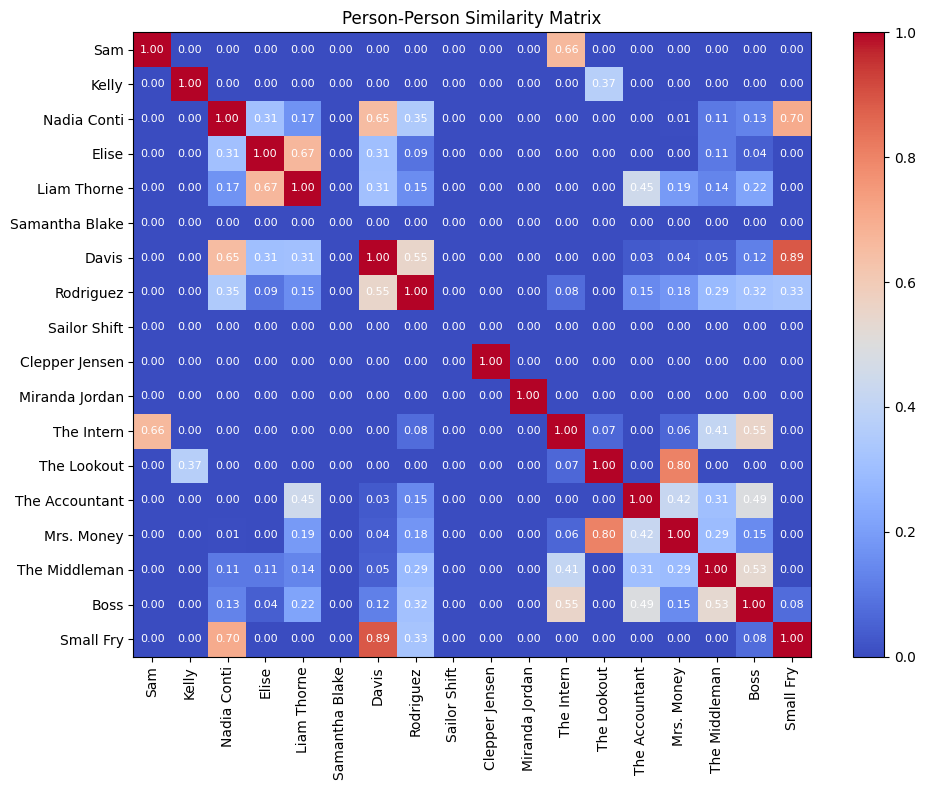

In [67]:
plot_heat_map(persons_similarity_matrix, title="Person-Person Similarity Matrix", cmap='coolwarm', annotate=True)

### Entity Similarity using cosine similarity

In [171]:
messages_df

,event_id,datetime,content,source,target,src_dict,tgt_dict,src_node,tgt_node
0,Event_Communication_1,2040-10-01 08:09:00,"Hey The Intern, it's The Lookout! Just spotted...","{'type': 'Entity', 'label': 'The Lookout', 'na...","{'type': 'Entity', 'label': 'The Intern', 'nam...","{'type': 'Entity', 'label': 'The Lookout', 'na...","{'type': 'Entity', 'label': 'The Intern', 'nam...",The Lookout,The Intern
1,Event_Communication_2,2040-10-01 08:10:00,"Hey The Lookout, The Intern here! I'd absolute...","{'type': 'Entity', 'label': 'The Intern', 'nam...","{'type': 'Entity', 'label': 'The Lookout', 'na...","{'type': 'Entity', 'label': 'The Intern', 'nam...","{'type': 'Entity', 'label': 'The Lookout', 'na...",The Intern,The Lookout
2,Event_Communication_3,2040-10-01 08:13:00,"Sam, it's Kelly! Let's meet at Sunrise Point a...","{'type': 'Entity', 'label': 'Kelly', 'name': '...","{'type': 'Entity', 'label': 'Sam', 'name': 'Sa...","{'type': 'Entity', 'label': 'Kelly', 'name': '...","{'type': 'Entity', 'label': 'Sam', 'name': 'Sa...",Kelly,Sam
3,Event_Communication_5,2040-10-01 08:16:00,"Mrs. Money, it's The Intern. Just checking in ...","{'type': 'Entity', 'label': 'The Intern', 'nam...","{'type': 'Entity', 'label': 'Mrs. Money', 'nam...","{'type': 'Entity', 'label': 'The Intern', 'nam...","{'type': 'Entity', 'label': 'Mrs. Money', 'nam...",The Intern,Mrs. Money
4,Event_Communication_6,2040-10-01 08:19:00,"Boss, it's Mrs. Money. I've reviewed our opera...","{'type': 'Entity', 'label': 'Mrs. Money', 'nam...","{'type': 'Entity', 'label': 'Boss', 'name': 'B...","{'type': 'Entity', 'label': 'Mrs. Money', 'nam...","{'type': 'Entity', 'label': 'Boss', 'name': 'B...",Mrs. Money,Boss
...,...,...,...,...,...,...,...,...,...
579,Event_Communication_994,2040-10-14 12:50:00,"Green Guardians, Oceanus City Council here. Yo...","{'type': 'Entity', 'label': 'Oceanus City Coun...","{'type': 'Entity', 'label': 'Green Guardians',...","{'type': 'Entity', 'label': 'Oceanus City Coun...","{'type': 'Entity', 'label': 'Green Guardians',...",Oceanus City Council,Green Guardians
580,Event_Communication_997,2040-10-14 12:51:00,"EcoVigil, Green Guardians HQ here. Your video ...","{'type': 'Entity', 'label': 'Green Guardians',...","{'type': 'Entity', 'label': 'EcoVigil', 'name'...","{'type': 'Entity', 'label': 'Green Guardians',...","{'type': 'Entity', 'label': 'EcoVigil', 'name'...",Green Guardians,EcoVigil
581,Event_Communication_999,2040-10-14 13:31:00,Defender to Mako. Be advised that conservation...,"{'type': 'Entity', 'label': 'Defender', 'name'...","{'type': 'Entity', 'label': 'Mako', 'name': 'M...","{'type': 'Entity', 'label': 'Defender', 'name'...","{'type': 'Entity', 'label': 'Mako', 'name': 'M...",Defender,Mako
582,Event_Communication_1001,2040-10-14 13:34:00,"Knowles, Mako here. Proceed to southern dock a...","{'type': 'Entity', 'label': 'Knowles', 'name':...","{'type': 'Entity', 'label': 'Davis', 'name': '...","{'type': 'Entity', 'label': 'Knowles', 'name':...","{'type': 'Entity', 'label': 'Davis', 'name': '...",Knowles,Davis


In [ ]:
communication_ids = set(messages_df['src_node']).union(set(messages_df['tgt_node']))
entities_df_with_communications = entities_df[entities_df['id'].isin(communication_ids)]

In [172]:
entity_entity_matrix = pd.DataFrame(
    0, 
    index=entities_df_with_communications['id'], 
    columns=entities_df_with_communications['id']
)
for i in range(messages_df.shape[0]):
    row = messages_df.iloc[i]
    source = row['src_node']
    target = row['tgt_node']
    if source not in entity_entity_matrix.index or target not in entity_entity_matrix.columns:
        continue
    entity_entity_matrix.loc[source, target] += 1
entity_entity_matrix = entity_entity_matrix + entity_entity_matrix.T
entity_entity_matrix = entity_entity_matrix.fillna(0)
entity_entity_matrix

id,Sam,Kelly,Nadia Conti,Elise,Liam Thorne,Samantha Blake,Davis,Rodriguez,Clepper Jensen,Miranda Jordan,...,Osprey,Defender,Northern Light,Remora,Knowles,City Officials,Paackland Harbor,Haacklee Harbor,Himark Harbor,Port Security
id,,,,,,,,,,,,,,,,,,,,,
Sam,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kelly,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Nadia Conti,0,0,0,3,4,0,5,1,0,0,...,0,0,0,1,0,0,0,2,0,0
Elise,0,0,3,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Liam Thorne,0,0,4,2,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Samantha Blake,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Davis,0,0,5,0,0,0,12,3,0,0,...,0,0,0,5,2,0,0,0,1,0
Rodriguez,0,0,1,0,0,0,3,8,0,0,...,0,0,0,2,0,0,0,0,0,0
Clepper Jensen,0,0,0,0,0,0,0,0,0,38,...,0,0,0,0,0,0,0,0,0,0


In [176]:
# Sum all the values in the matrix
entity_entity_matrix_sum = entity_entity_matrix.sum().sum() / 2
print(f"Sum of all values in the entity-entity matrix: {entity_entity_matrix_sum:.4f}")

Sum of all values in the entity-entity matrix: 584.0000


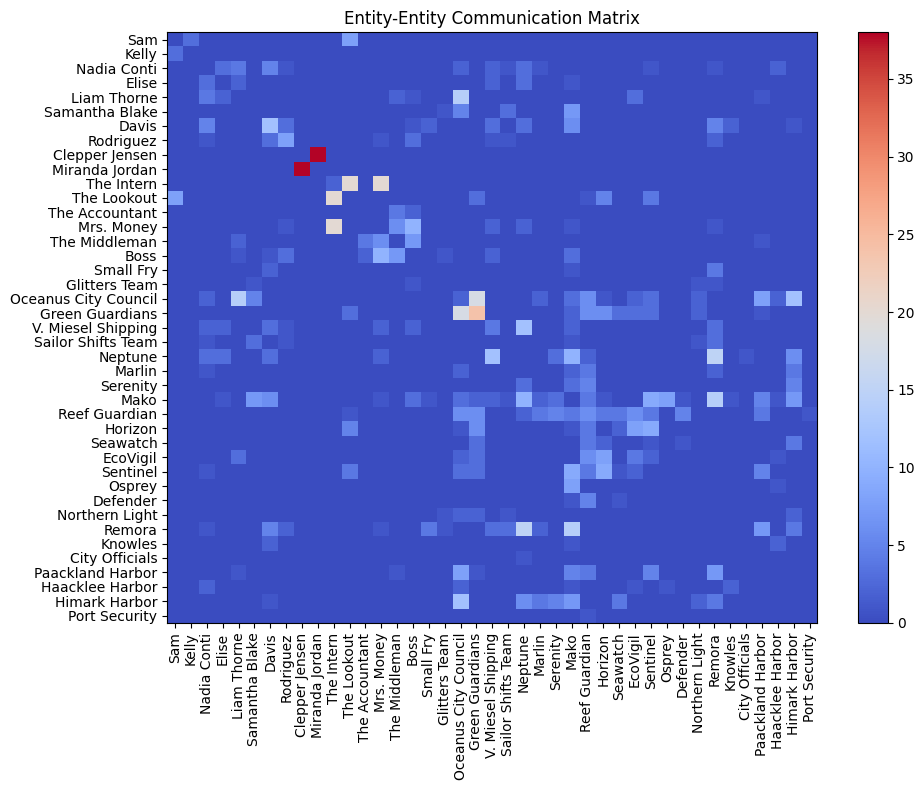

In [173]:
plot_heat_map(entity_entity_matrix, title="Entity-Entity Communication Matrix", cmap='coolwarm', annotate=False)

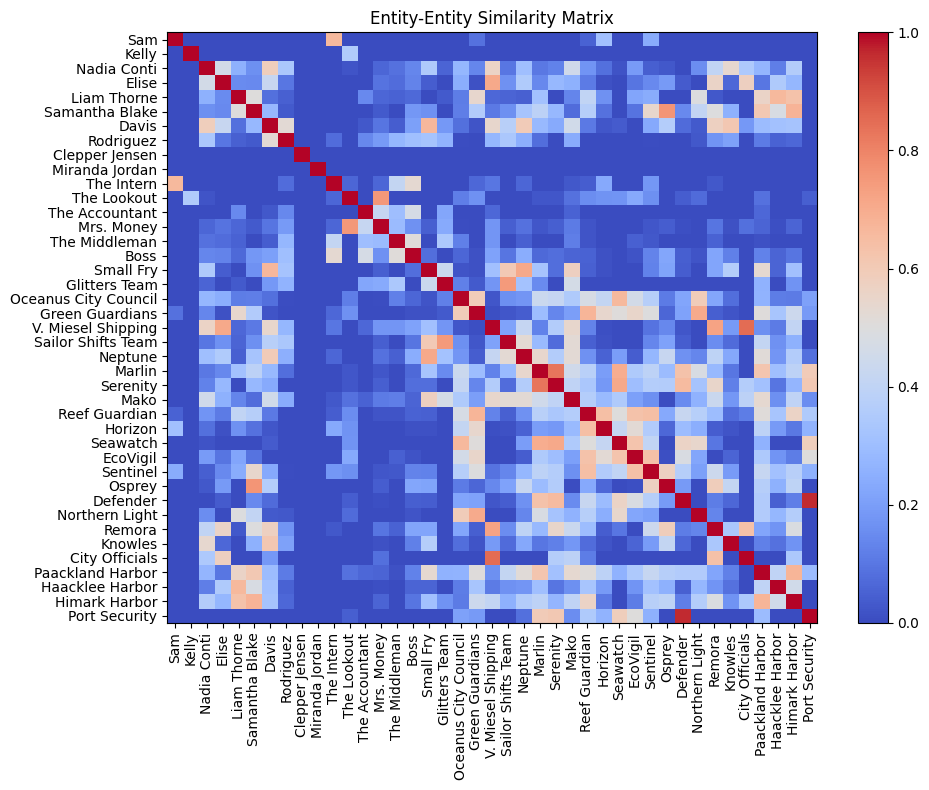

In [177]:
entity_similarity_matrix = cosine_similarity(entity_entity_matrix)
entity_similarity_matrix = pd.DataFrame(entity_similarity_matrix, index=entity_entity_matrix.index, columns=entity_entity_matrix.index)
entity_similarity_matrix
plot_heat_map(entity_similarity_matrix, title="Entity-Entity Similarity Matrix", cmap='coolwarm', annotate=False)

In [178]:
entity_similarity_matrix.to_csv('../data/MC3_entity_similarity_matrix.csv', index=True)

### Person topics matrix similarity

In [29]:
%pip install bertopic>=0.14.0

Note: you may need to restart the kernel to use updated packages.


In [30]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def extract_topics_tfidf(texts, num_topics=15):
    """Extract topics using TF-IDF keywords"""
    if len(texts) < 2:
        return [["insufficient", "data"]], [[1.0] for _ in texts]

    try:
        # Create TF-IDF matrix
        tfidf = TfidfVectorizer(
            stop_words="english",
            ngram_range=(1, 2),
            max_features=5000,
            min_df=2,
            max_df=0.8,
        )
        tfidf_matrix = tfidf.fit_transform(texts)

        # Get overall document scores
        doc_scores = tfidf_matrix.toarray()

        # Get top keywords across all documents
        feature_names = tfidf.get_feature_names_out()
        total_scores = np.sum(doc_scores, axis=0)
        top_indices = total_scores.argsort()[-num_topics:][::-1]

        # Create topics - each topic is a single keyword
        topics = [[feature_names[i]] for i in top_indices]

        # Create document-topic matrix (each doc has scores for each keyword)
        doc_topics = doc_scores[:, top_indices].tolist()

        return topics, doc_topics

    except Exception as e:
        print(f"TF-IDF extraction failed: {str(e)}")
        return [["error", "processing"]], [[1.0] for _ in texts]
    
def extract_topics_bertopic(texts, min_topic_size=5, top_n=10):
    """Extract topics using BERTopic"""
    if len(texts) < min_topic_size * 2:
        min_topic_size = max(2, len(texts) // 4)

    try:
        # Use KeyBERT for better keyword extraction
        representation_model = KeyBERTInspired()

        topic_model = BERTopic(
            min_topic_size=min_topic_size,
            nr_topics="auto",
            language="english",
            calculate_probabilities=True,
            representation_model=representation_model,
            verbose=False,
        )
        topics, probs = topic_model.fit_transform(texts)

        # Get topic keywords
        topic_keywords = {}
        unique_topics = set(topics)
        if -1 in unique_topics:
            unique_topics.remove(-1)  # Remove outlier topic

        for topic_id in unique_topics:
            try:
                keywords = topic_model.get_topic(topic_id)
                topic_keywords[topic_id] = [word for word, _ in keywords[:top_n]]
            except:
                continue

        if not topic_keywords:
            # Fallback if no topics found
            return extract_topics_tfidf(texts) + (None,)

        # Prepare document topic weights
        doc_topics = []
        max_topic_id = max(topic_keywords.keys()) if topic_keywords else 0

        for i, doc_topic in enumerate(topics):
            weights = [0.0] * (max_topic_id + 1)
            if doc_topic in topic_keywords:
                weights[doc_topic] = 1.0
            doc_topics.append(weights)

        # Convert to ordered list of topic keywords
        topics_list = []
        for i in range(max_topic_id + 1):
            if i in topic_keywords:
                topics_list.append(topic_keywords[i])
            else:
                topics_list.append([])

        return topics_list, doc_topics, topic_model
    except Exception as e:
        print(f"BERTopic failed: {str(e)}")
        # Fallback to TF-IDF
        topics, doc_topics = extract_topics_tfidf(texts)
        return topics, doc_topics, None

In [33]:
topics_listm, doc_topics, topic_model = extract_topics_bertopic(messages_df['content'].tolist())
if topic_model:
    print(f"Extracted {len(topics_listm)} topics using BERTopic.")
else:
    print("BERTopic failed, using TF-IDF instead.")
    topics_listm, doc_topics = extract_topics_tfidf(messages_df['content'].tolist())

Extracted 9 topics using BERTopic.


In [47]:
len(topics_listm)

9

In [51]:
# Create a dataframe with the topics X messages
topics_df = pd.DataFrame(doc_topics, columns=[f"Topic_{i}" for i in range(len(topics_listm))])
topics_df['source'] = messages_df['source']
# Use source as the index
topics_df.set_index('source', inplace=True)

In [57]:
# Merge the rows with the same source
topics_df = topics_df.groupby(topics_df.index).sum()
topics_df


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8
source,,,,,,,,,
Boss,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Clepper Jensen,1.0,0.0,17.0,0.0,0.0,2.0,0.0,0.0,0.0
Davis,8.0,10.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
Defender,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EcoVigil,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Elise,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Glitters Team,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
Green Guardians,34.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0
Haacklee Harbor,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


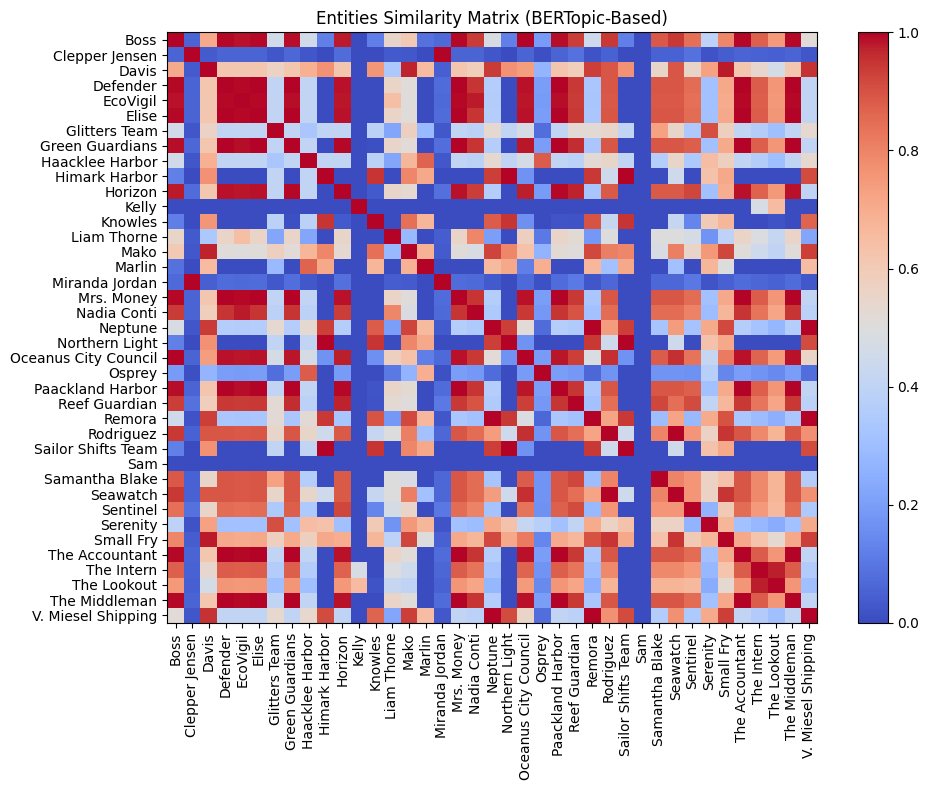

In [97]:
entities_similarity_matrix = cosine_similarity(topics_df)
entities_similarity_matrix = pd.DataFrame(entities_similarity_matrix, index=topics_df.index, columns=topics_df.index)
plot_heat_map(entities_similarity_matrix, title="Entities Similarity Matrix (BERTopic-Based)", cmap='coolwarm')

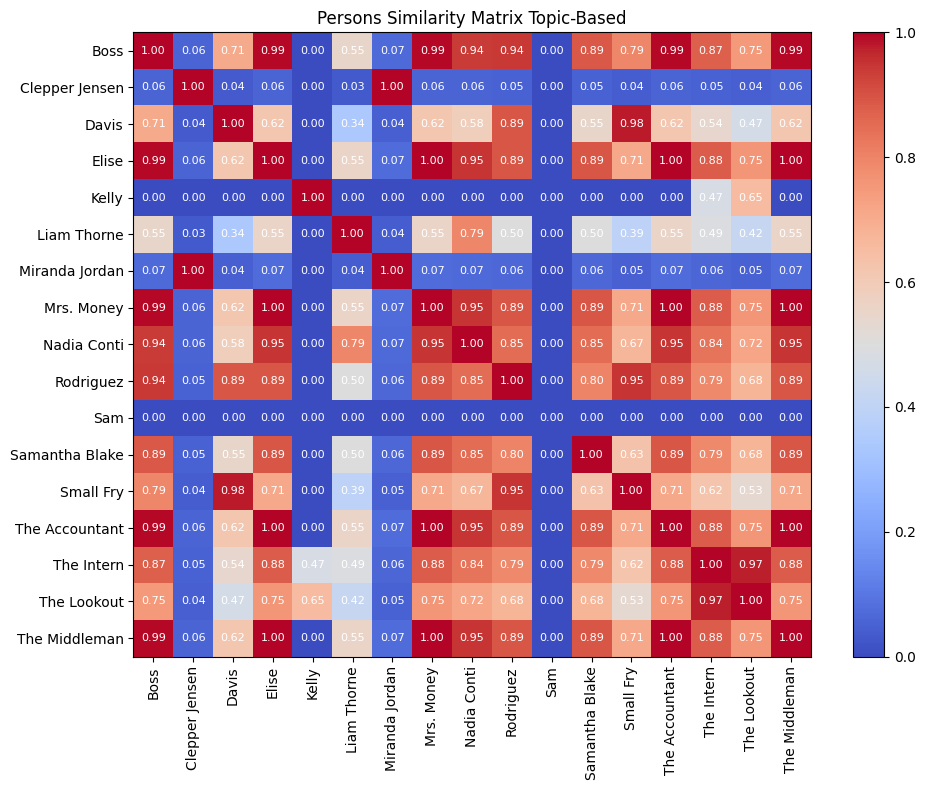

In [69]:
topics_df_persons = topics_df[topics_df.index.isin(persons['id'])]
persons_similarity_topics_matrix = cosine_similarity(topics_df_persons)
persons_similarity_topics_matrix = pd.DataFrame(persons_similarity_topics_matrix, index=topics_df_persons.index, columns=topics_df_persons.index)
plot_heat_map(persons_similarity_topics_matrix, title="Persons Similarity Matrix Topic-Based", cmap='coolwarm', annotate=True)

In [70]:
def analyze_messages(messages_df, entity_1, entity_2):
    """
    Analyze messages from the DataFrame and print messages from specific sources.
    """
    # I want to see the messages of the The interm and the lookout
    interm_messages = messages_df[messages_df['source'] == entity_1]
    lookout_messages = messages_df[messages_df['source'] == entity_2]

    print(f"Messages from {entity_1}:")
    for msg in interm_messages['content'].tolist():
        print(msg)

    print(f"\nMessages from {entity_2}:")
    for msg in lookout_messages['content'].tolist():
        print(msg)

In [71]:
analyze_messages(messages_df, 'Boss', 'Elise')

Messages from Boss:
Mrs. Money, this is Boss. I'm available tomorrow at 3 PM to discuss funding allocations. Bring the updated projections for our tourism ventures. We need to ensure everything looks legitimate before meeting The Middleman next week.
Middleman, this is Boss. I'd like to move our meeting forward to discuss some promising opportunities near Nemo Reef. My accountant has identified potential for expansion there. Can you meet earlier than planned?
Middleman, this is Boss. Let's meet tomorrow at 4PM at the usual spot by the marina. I'll bring the tourism portfolio with Nemo Reef projections. Curious about those council updates that might help our expansion.
Mrs. Money, this is Boss. After speaking with The Middleman, I'm confident about our Nemo Reef opportunity. He mentioned a potential loophole in protection zones. Let's discuss this during our 3PM meeting along with funding allocations.
Mrs. Money, this is Boss. Abort all Nemo Reef operations immediately. Conservation ves